In [3]:
import sys
#sys.path.insert(0, "../input/timm-efficientdet-pytorch")
#sys.path.insert(0, "../input/omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold, KFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch.nn as nn
from glob import glob
from eval.mAP import *


SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [4]:
"""
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
"""
#marking = pd.DataFrame({"image_id":[os.path.splitext(i)[0] for i in os.listdir("/home/ubuntu/datasets/signate/fish/train_images")]})
annos = os.listdir("/home/ubuntu/datasets/signate/fish/train_annotations")
anno_path = "/home/ubuntu/datasets/signate/fish/train_annotations/"
import json
img_id = []
w = []
#CLASSES = ["Jumper School","Breezer School","others"]
CLASSES = ["Jumper School","Breezer School","Wake", "Ripple","Smooth Surface","Cloud"]

for anno in annos:
    n = 0
    with open(anno_path + anno) as f:
        l = json.load(f)["labels"]
        l_keys = l.keys()
        for k in l_keys:
            if k in ["Jumper School","Breezer School"]:
                n += len(l[k])
    if not n == 0:
        img_id.append(anno[:-5])
   
    
marking = pd.DataFrame({"image_id":img_id})


#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf = KFold(n_splits=5, shuffle=True, random_state=14)


df_folds = marking[['image_id']].copy()
#df_folds.loc[:, 'bbox_count'] = 1
#df_folds = df_folds.groupby('image_id').count()
#df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
#df_folds.loc[:, 'stratify_group'] = np.char.add(
#    df_folds['source'].values.astype(str),
#    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
#)
df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index)):
#for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [5]:

"""
annos = os.listdir("/home/ubuntu/datasets/signate/fish/train_annotations")
anno_path = "/home/ubuntu/datasets/signate/fish/train_annotations/"
import json
img_id = []
w = []

for anno in annos:
    #print(anno[:-4])
    n = 0
    with open(anno_path + anno) as f:
        l = json.load(f)["labels"]
        l_keys = l.keys()
        for k in l_keys:
            if k in ["Jumper School","Breezer School"]:

                n += len(l[k])
    #print(n)
    if not n == 0:
        img_id.append(anno[:-4])
            #for box in l[k]:
                #print(box)
    
marking = pd.DataFrame({"image_id":img_id})
"""


'\nannos = os.listdir("/home/ubuntu/datasets/signate/fish/train_annotations")\nanno_path = "/home/ubuntu/datasets/signate/fish/train_annotations/"\nimport json\nimg_id = []\nw = []\n\nfor anno in annos:\n    #print(anno[:-4])\n    n = 0\n    with open(anno_path + anno) as f:\n        l = json.load(f)["labels"]\n        l_keys = l.keys()\n        for k in l_keys:\n            if k in ["Jumper School","Breezer School"]:\n\n                n += len(l[k])\n    #print(n)\n    if not n == 0:\n        img_id.append(anno[:-4])\n            #for box in l[k]:\n                #print(box)\n    \nmarking = pd.DataFrame({"image_id":img_id})\n'

In [6]:
def get_train_transforms():
    return A.Compose(
        [
#            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=2, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [10]:
TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'
TRAIN_ROOT_PATH = "/home/ubuntu/datasets/signate/fish/train_images"
ANNO_ROOT_PATH = "/home/ubuntu/datasets/signate/fish/train_annotations/"

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()
        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.0:
            image, boxes, labels = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])
        
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = []
        labels = []
        label_id = CLASSES
        with open(ANNO_ROOT_PATH + image_id + ".json") as f:
            l = json.load(f)["labels"]
            l_keys = l.keys()
            for k in l_keys:
                if k in label_id:
                    for box in l[k]:
                        boxes.append(box)
                        labels.append(min(label_id.index(k) + 1,3))

        return image, np.array(boxes), labels
    
    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        
        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [11]:
fold_number = 0

train_dataset = DatasetRetriever(
    #image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    image_ids=df_folds[df_folds['fold'] != fold_number].image_id.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].image_id.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)
print(len(train_dataset), len(validation_dataset))

2367 592


tensor([[181.3333, 160.9333, 209.3037, 199.2000],
        [170.4296, 179.7333, 180.6222, 198.0000],
        [114.0148, 155.8667, 167.8222, 265.0667],
        [208.8296, 130.6667, 336.8296, 213.8667],
        [183.7037, 213.8667, 229.9259, 247.0667]], dtype=torch.float64)


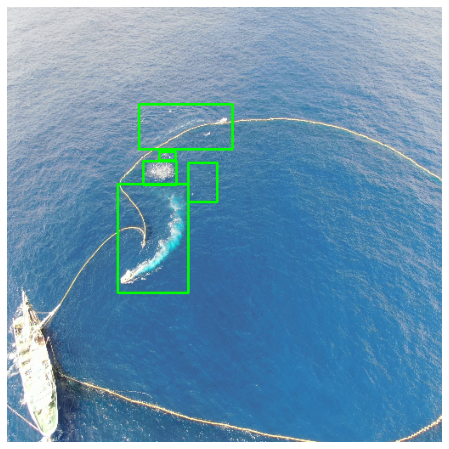

In [12]:
image, target, image_id = validation_dataset[1]
print(target["boxes"])

boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss, mean_AP = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)
            for c in CLASSES[:3]:
                print(c, mean_AP[c])
            

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        det_boxes = []
        det_scores = []
        det_labels = []
        true_boxes = []
        true_labels = []
        true_difficulties = []
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)

                outputs = self.model(images, target_res)
                loss = outputs["loss"]
                summary_loss.update(loss.detach().item(), batch_size)
                for i in range(batch_size):
                    det_boxes.append(outputs["detections"][i,:10,:4])
                    det_scores.append(outputs["detections"][i,:10,4])
                    det_labels.append(outputs["detections"][i,:10,5])
                    true_boxes.append(boxes[i][:,[1,0,3,2]])
                    true_labels.append(labels[i])
                    true_difficulties.append(torch.tensor([0] * len(labels[i])))
  
                                        
        mean_AP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, CLASSES)
        return summary_loss, mean_AP[0]

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):

            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )


            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            
            self.optimizer.zero_grad()

            output = self.model(images, {"bbox":boxes, "cls":labels})
            loss = output["loss"]
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')


In [20]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 2
    n_epochs = 40 # n_epochs = 40
    lr = 0.0002

    folder = 'n_class_effdet5-cutmix-augmix'
    #folder = 'effdet5-cutmix-augmix-xyxy'


    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    #fitter.load("effdet5-cutmix-augmix/last-checkpoint.bin")
    #fitter.load("n_class_effdet5-cutmix-augmix/best-checkpoint-018epoch.bin")
    fitter.fit(train_loader, val_loader)

In [22]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    config.num_classes = 3
    config.image_size = (512,512)

    net = EfficientDet(config, pretrained_backbone=False)
    #checkpoint = torch.load("effdet5-cutmix-augmix/best-checkpoint-002epoch.bin")
    #net.load_state_dict(checkpoint['model_state_dict'])
    #checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')

    net.reset_head(num_classes=config.num_classes)

    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    return DetBenchTrain(net, config)

net = get_net()
#net = nn.DataParallel(net)

In [23]:
run_training()

Fitter prepared. Device is cuda:0

2021-01-19T13:25:07.179588
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 28.43493, time: 656.84660
[RESULT]: Val. Epoch: 0, summary_loss: 13.88967, time: 85.87262
Jumper School 0.0022632968612015247
Breezer School 0.002625182271003723
Wake 0.0025728989858180285

2021-01-19T13:37:32.710997
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 1.61347, time: 648.12007
[RESULT]: Val. Epoch: 1, summary_loss: 22.29133, time: 83.70238
Jumper School 0.0025136154145002365
Breezer School 0.00808862317353487
Wake 0.00336700351908803

2021-01-19T13:49:46.756623
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 1.54463, time: 652.73690
[RESULT]: Val. Epoch: 2, summary_loss: 14.07995, time: 86.39725
Jumper School 0.010695187374949455
Breezer School 0.008430241607129574
Wake 0.006887052673846483

2021-01-19T14:02:08.126843
LR: 0.0001
[RESULT]: Train. Epoch: 3, summary_loss: 1.48440, time: 649.27209
[RESULT]: Val. Epoch: 3, summary_loss: 19.61918, time: 84.367

[RESULT]: Train. Epoch: 31, summary_loss: 1.17938, time: 404.93538
[RESULT]: Val. Epoch: 31, summary_loss: 5.41349, time: 56.29089
Jumper School 0.19447511434555054
Breezer School 0.04816041886806488
Wake 0.11590223014354706

2021-01-19T18:30:52.714471
LR: 9.765625e-08
[RESULT]: Train. Epoch: 32, summary_loss: 1.17581, time: 405.13719
[RESULT]: Val. Epoch: 32, summary_loss: 7.58881, time: 52.90649
Jumper School 0.19667816162109375
Breezer School 0.11043530702590942
Wake 0.11487367004156113

2021-01-19T18:38:32.929932
LR: 9.765625e-08
[RESULT]: Train. Epoch: 33, summary_loss: 1.16834, time: 401.17162
[RESULT]: Val. Epoch: 33, summary_loss: 8.79590, time: 58.60317
Jumper School 0.2003169059753418
Breezer School 0.04361642897129059
Wake 0.11150918900966644

2021-01-19T18:46:14.947849
LR: 4.8828125e-08
[RESULT]: Train. Epoch: 34, summary_loss: 1.17759, time: 406.71528
[RESULT]: Val. Epoch: 34, summary_loss: 5.20276, time: 53.43307
Jumper School 0.19657276570796967
Breezer School 0.03964494

In [ ]:
"""
CLASSES = ["Jumper School","Breezer School","Wake", "Ripple","Smooth Surface","Cloud"]

[RESULT]: Train. Epoch: 26, summary_loss: 0.75969, time: 652.80592
[RESULT]: Val. Epoch: 26, summary_loss: 0.94934, time: 85.19014
Jumper School 0.4164049029350281
Breezer School 0.40805521607398987
Wake 0.5604093074798584
Ripple 0.2741076946258545
Smooth Surface 0.39223915338516235
Cloud 0.16597795486450195

2021-01-19T12:21:55.183250
LR: 2.5e-05
[RESULT]: Train. Epoch: 27, summary_loss: 0.75432, time: 658.85861
[RESULT]: Val. Epoch: 27, summary_loss: 1.02426, time: 81.73925
Jumper School 0.3972359299659729
Breezer School 0.3808251917362213
Wake 0.4617810845375061
Ripple 0.23634442687034607
"""

In [34]:
class submitDataset(Dataset):
    def __init__(self, src = "/home/ubuntu/datasets/signate/fish/test_images/", transform = False):
        super().__init__()
        self.src_path = src
        self.transforms = transform
        self.image_ids = os.listdir(self.src_path)

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]  
        image= self.load_image(image_id)
        sample = {
            "img_scale":torch.tensor(1.0).float(),
            "img_size":torch.tensor([512,512])}
        if self.transforms:
            image = self.transforms(**{'image': image})
        return image["image"], sample, image_id

        #return torch.tensor(image["image"], dtype = torch.float), sample, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image(self, image_id):
        image = cv2.imread(f'{self.src_path}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
def get_test_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0, 
        )

sub_dataset = submitDataset(transform = get_test_transforms())

In [154]:
for step, (images, targets, image_ids) in enumerate(validation_dataset):
    targets["box"]
    break
    

0


In [19]:
image,sample = sub_dataset[2]
#print(sample)
#boxes = target['boxes'].cpu().numpy().astype(np.int32)
boxes = out[2][0][:, :4]
boxes = boxes[:10]

numpy_image = image.permute(1,2,0).cpu().numpy()
numpy_image = cv2.resize(numpy_image, (512, 512))
fig, ax = plt.subplots(1, 1, figsize=(10, 16))

for box in boxes:
    box = box.cpu().detach().numpy()
    #print(box)
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

NameError: name 'sub_dataset' is not defined

In [78]:

def test_output(test_loader, weight = "effdet5-cutmix-augmix/best-checkpoint-014epoch.bin"):
    checkpoint = torch.load(weight)
    net.model.load_state_dict(checkpoint['model_state_dict'])
    net.to('cuda:2')
    net.eval()
    summary_loss = AverageMeter()
    t = time.time()
    output_detections = []
    ids = []
    device = "cuda:2"
    for step, (images, targets, image_ids) in enumerate(test_loader):
        print("\r", image_ids, end = "")
        with torch.no_grad():
            #images = torch.stack(images)
            images = images.unsqueeze(0)
            batch_size = images.shape[0]
            images = images.to(device).float().to(device)
            boxes = torch.tensor([[0,1,2,3]]).float().to(device)
            labels = torch.tensor([1]).to(device)

            #loss= self.model(images, {"bbox":boxes, "cls":labels})["loss"]
            target_res = {}
            target_res['bbox'] = boxes
            target_res['cls'] = labels 
            target_res["img_scale"] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(device)
            target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(device)

            outputs = net(images, target_res)
            output_detections.append(outputs["detections"])
            ids.append(image_ids)


    return output_detections, ids
#o,ids = test_output(sub_dataset)
train_o, _ = test_output(train_dataset)

 train_3386

In [41]:
classes = ["Jumper School","Breezer School"]

In [109]:
for x in o[:10]:
    print(x[0,0,4])

tensor(0.3152, device='cuda:2')
tensor(0.2258, device='cuda:2')
tensor(0.1553, device='cuda:2')
tensor(0.1092, device='cuda:2')
tensor(0.0729, device='cuda:2')
tensor(0.5363, device='cuda:2')
tensor(0.3437, device='cuda:2')
tensor(0.0804, device='cuda:2')
tensor(0.5268, device='cuda:2')
tensor(0.5843, device='cuda:2')


In [113]:
def nms(boxes, scores, overlap=0.2, top_k=20):
    """
    Non-Maximum Suppressionを行う関数。
    boxesのうち被り過ぎ（overlap以上）のBBoxを削除する。
    Parameters
    ----------
    boxes : [確信度閾値（0.01）を超えたBBox数,4]
        BBox情報。
    scores :[確信度閾値（0.01）を超えたBBox数]
        confの情報
    Returns
    -------
    keep : リスト
        confの降順にnmsを通過したindexが格納
    count：int
        nmsを通過したBBoxの数
    """

    # returnのひな形を作成
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep：torch.Size([確信度閾値を超えたBBox数])、要素は全部0

    # 各BBoxの面積areaを計算
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxesをコピーする。後で、BBoxの被り度合いIOUの計算に使用する際のひな形として用意
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # socreを昇順に並び変える
    v, idx = scores.sort(0)

    # 上位top_k個（200個）のBBoxのindexを取り出す（200個存在しない場合もある）
    idx = idx[-top_k:]

    # idxの要素数が0でない限りループする
    while idx.numel() > 0:
        i = idx[-1]  # 現在のconf最大のindexをiに

        # keepの現在の最後にconf最大のindexを格納する
        # このindexのBBoxと被りが大きいBBoxをこれから消去する
        keep[count] = i
        count += 1

        # 最後のBBoxになった場合は、ループを抜ける
        if idx.size(0) == 1:
            break

        # 現在のconf最大のindexをkeepに格納したので、idxをひとつ減らす
        idx = idx[:-1]

        # -------------------
        # これからkeepに格納したBBoxと被りの大きいBBoxを抽出して除去する
        # -------------------
        # ひとつ減らしたidxまでのBBoxを、outに指定した変数として作成する
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # すべてのBBoxに対して、現在のBBox=indexがiと被っている値までに設定(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # wとhのテンソルサイズをindexを1つ減らしたものにする
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clampした状態でのBBoxの幅と高さを求める
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 幅や高さが負になっているものは0にする
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clampされた状態での面積を求める
        inter = tmp_w*tmp_h

        # IoU = intersect部分 / (area(a) + area(b) - intersect部分)の計算
        rem_areas = torch.index_select(area, 0, idx)  # 各BBoxの元の面積
        union = (rem_areas - inter) + area[i]  # 2つのエリアのANDの面積
        IoU = inter/union

        # IoUがoverlapより小さいidxのみを残す
        idx = idx[IoU.le(overlap)]  # leはLess than or Equal toの処理をする演算です
        # IoUがoverlapより大きいidxは、最初に選んでkeepに格納したidxと同じ物体に対してBBoxを囲んでいるため消去


    return keep[:count]


# SSDの推論時にconfとlocの出力から、被りを除去したBBoxを出力する

In [119]:
submit = {}
for i in range(len(o)):
    image_id = ids[i]
    submit[image_id] = {}
    submit[image_id][classes[0]] = []
    submit[image_id][classes[1]] = []


    bbox = o[i].cpu()[0, :, :4]
    score = o[i].cpu()[0, :, 4]
    c = o[i].cpu()[0, :, 5]
    nms_index = nms(bbox, score)
    score,bbox, c = score[nms_index], bbox[nms_index], c[nms_index]
    th = 0.05
    index = score > th
    score, bbox, c = score[index], bbox[index], c[index]
    h = 2160
    w = 3840
    for i in range(len(bbox[:5])):
        x1, y1, x2, y2 = bbox[i].detach().numpy().astype(float)
        x1 = int(x1 / 512 * w)
        x2 = int(x2 / 512 * w)
        y1 = int(y1 / 512 * h)
        y2 = int(y2 / 512 * h)
        cls = classes[int(c[i].detach().numpy()-1)]
        submit[image_id][cls].append([x1,y1,x2,y2])


In [120]:
with open('submit.json', 'w') as f:
    json.dump(submit, f, indent=4)

In [17]:
def visualize(idx, model_out):
    images, target, image_id = sub_dataset[idx]
    #images, target, image_id = train_dataset[idx]
    print(image_id)

    
    #boxes = target['boxes'].cpu().numpy().astype(np.int32)
    bbox = model_out[idx].cpu()[0, :, :4]
    score = model_out[idx].cpu()[0, :, 4]
    c = model_out[idx].cpu()[0, :, 5]
    nms_index = nms(bbox, score)
    score,bbox, c = score[nms_index], bbox[nms_index], c[nms_index]
    print(len(score),score)
    th = 0.2
    #score,bbox, c = score[nms_index.unsqueeze(1)], bbox[nms_index].detach().numpy().astype(np.int32), c[nms_index]
    index = score > th
    score, bbox, c = score[index], bbox[index], c[index]
    print(len(score))

    
    numpy_image = images.permute(1,2,0).cpu().numpy()
    numpy_image_resized = cv2.resize(numpy_image, (512, 512))

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in bbox[:5]:
        print(box)
        box = box.detach().numpy()
        #cv2.rectangle(numpy_image_resized, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
        cv2.rectangle(numpy_image_resized, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

    #ax.set_axis_off()
    ax.imshow(numpy_image_resized)
    
        
visualize(9, o)

NameError: name 'o' is not defined